# Prepare Env

In [4]:
# Library

import platform
import sys
import os

import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.amp import autocast, GradScaler
import torchvision
from glob import glob
import cv2

from scipy.stats import multivariate_normal

from PIL import Image

from tqdm import tqdm

# import albumentations as A
from sklearn.model_selection import train_test_split
# import segmentation_models_pytorch as smp

In [ ]:
# Find session type
def find_session_type():
    # windows
    if os.name == 'nt':
        path = '../input/data/'

        import japanize_matplotlib
        sns.set(font="IPAexGothic")

    elif platform.system()  == 'Darwin':
        # Mac
        path = '../input/data/'
        return 'mac'

    elif os.name == 'posix':
    # Kaggle
        if 'KAGGLE_DATA_PROXY_TOKEN' in os.environ.keys():
            print('This is kaggle session')
            return 'kaggle'

    # Google Colab
        else:
            print('This is colab session')
            # セッションの残り時間の確認
            !cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 / 60 / 60 "h)"}'
            return 'colab'
    # Mac
    # elif 'MAC' in os.environ.keys():
    #     print('This is mac session')
    #     return 'mac'
# Example usage:
if find_session_type() == 'kaggle':
    print("Running in a Kaggle notebook")
elif find_session_type() == 'mac':
    print("Running on a Mac")
    path = '../input/data/'

elif find_session_type() == 'colab':
    from google.colab import drive
    print("Running in Google Colab")
    drive.mount('/content/drive')
    os.makedirs('/content/logs', exist_ok=True)
    os.makedirs('/content/kaggle/input', exist_ok=True)
    os.makedirs('/content/kaggle/output', exist_ok=True)
else:
    print("Not running in a Kaggle notebook or Google Colab")

# if is_google_colab():
#   byu_locating_bacterial_flagellar_motors_2025_path = kagglehub.competition_download('byu-locating-bacterial-flagellar-motors-2025')

#   print('Data source import complete.')

class Config:
    def __init__(self):
        self.seed = 42
        self.debug = False
        self.epochs = 10
        self.num_classes = 86
        self.ramdom_seed = 42
        self.batch_size = 4
        self.no_motor_use = 10

        self.train_size = 0.8
        self.voxel_size = 256
        # Torch settings
        self.translate = 0.5
        self.lr = 1e-4
        self.grad_norm = 0.1
        self.init_scale = 4096

        self.root_dir = ''
        if find_session_type() == 'kaggle':
            self.root_dir = '/kaggle/'
        elif find_session_type() == 'colab':
            self.root_dir = '/content/kaggle/'
        elif find_session_type() == 'mac':
            self.root_dir = '../'
        self.working_dir = os.path.join(self.root_dir, 'working')
        self.pred_dir = os.path.join(self.root_dir, 'input', 'byu-locating-bacterial-flagellar-motors-2025', 'test')
        self.data_dir = os.path.join(self.root_dir, 'input', 'byu-locating-bacterial-flagellar-motors-2025')
        self.output_dir = os.path.join(self.root_dir, 'output')
        self.dataset_dir = os.path.join(self.working_dir, 'dataset')
        self.train_image_dir = os.path.join(self.dataset_dir, 'images','train')
        self.train_label_dir = os.path.join(self.dataset_dir, 'labels','train')
        self.val_image_dir = os.path.join(self.dataset_dir, 'images','val')
        self.val_label_dir = os.path.join(self.dataset_dir, 'labels','val')
        self.pred_dataset_dir = os.path.join(self.dataset_dir, 'test')

        os.makedirs(self.dataset_dir, exist_ok=True)
        os.makedirs(self.train_image_dir, exist_ok=True)
        os.makedirs(self.train_label_dir, exist_ok=True)
        os.makedirs(self.val_image_dir, exist_ok=True)
        os.makedirs(self.val_label_dir, exist_ok=True)

        assert os.path.exists(self.data_dir), f"Data directory {self.data_dir} does not exist."

        random.seed(self.ramdom_seed)
        np.random.seed(self.ramdom_seed)
        torch.manual_seed(self.ramdom_seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(self.ramdom_seed)
            torch.backends.cudnn.deterministic = True

class GPUProfiler:
    def __init__(self, name):
        self.name = name
        self.start_time = None

    def __enter__(self):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        self.start_time = time.time()
        return self

    def __exit__(self, *args):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        elapsed = time.time() - self.start_time
        # print(f"[PROFILE] {self.name}: {elapsed:.3f}s")

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
if device.startswith('cuda'):
    # Set CUDA optimization flags
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    torch.backends.cuda.matmul.allow_tf32 = True  # Allow TF32 on Ampere GPUs
    torch.backends.cudnn.allow_tf32 = True

    # Print GPU info
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert to GB
    print(f"Using GPU: {gpu_name} with {gpu_mem:.2f} GB memory")

    # Get available GPU memory and set batch size accordingly
    free_mem = gpu_mem - torch.cuda.memory_allocated(0) / 1e9
    BATCH_SIZE = max(8, min(32, int(free_mem * 4)))  # 4 images per GB as rough estimate
    print(f"Dynamic batch size set to {BATCH_SIZE} based on {free_mem:.2f}GB free memory")
else:
    print("GPU not available, using CPU")
    BATCH_SIZE = 4  # Reduce batch size for CPU

config = Config()

config.batch_size = BATCH_SIZE

Running on a Mac
GPU not available, using CPU


# Helper Setup

For create dataset, train, and predict

In [24]:
def make_crop_gaussian_box(
    motor_centers:pd.DataFrame,
    volume_shape=(256, 256, 256),
    crop_origin=(0, 0, 0),
    cov = [[0.1,0,0],[0,0.1,0],[0,0,0.1]],
    shapness_factor=2
):
    """
    Calculate Gaussian distribution function for a given motor center

    Args:
        motor_centers(pd.DataFrame): Each motor center coordinates
        volume_shape()
    """

    dz, dy, dx = volume_shape
    z0, y0, x0 = crop_origin
    # create 3d mesh
    z = np.linspace(0, 1, dz)
    y = np.linspace(0, 1, dy)
    x = np.linspace(0, 1, dx)
    z, y, x = np.meshgrid(z, y, x)

    pdf = np.zeros((dz, dy, dx))
    if motor_centers.iloc[0,0] == -1:
        pdf = np.zeros((dz, dy, dx))
        return pdf
    for row in motor_centers.iterrows():
        motor_cen = row[1].values
        motor_cen = [(motor_cen[0]-z0)/dz, (motor_cen[1]-y0)/dy, (motor_cen[2]-x0)/dx]
        rv = multivariate_normal(mean=motor_cen, cov=cov)
        pdf += rv.pdf(np.stack((z, y, x), axis=-1))
    
    pdf = pdf ** shapness_factor
    pdf = np.clip(pdf, 0, 1)
    return torch.tensor(pdf, dtype=torch.float32).to(device)

def image_processor(image_path:os.PathLike, start_y:int, start_x:int)->np.ndarray:
    """
    Open image, convert to grayscale, normalize, and crop

    Args:
        image_path(os.PathLike): Path to the image
        start_x:int, start_y:int): Index of the crop starting
    """
    _img = cv2.imread(image_path)
    _gamma22LUT = np.array([((i / 255) ** (1 / 2.2)) * 255 for i in range(256)]).astype(np.uint8)
    _img = cv2.LUT(_img, _gamma22LUT)
    _img = cv2.normalize(_img, None, 0, 255, cv2.NORM_MINMAX)
    _img_gray = cv2.cvtColor(_img, cv2.COLOR_BGR2GRAY)
    _img_gray = cv2.normalize(_img_gray, None, 0, 255, cv2.NORM_MINMAX)
    _array = _img_gray[start_y:start_y+config.voxel_size, start_x:start_x+config.voxel_size]
    return _array

def crop_pos_set(z_max:int, y_max:int, x_max:int, start_z:int, start_y:int, start_x:int):
    """
    z_max, y_max, x_max: 全体画像のサイズ
    start_z, start_y, start_x: cropの開始位置
    """

    if start_z < 0:
        start_z = 0
    elif start_z > z_max - config.voxel_size:
        start_z = z_max - config.voxel_size
    if start_y < 0:
        start_y = 0
    elif start_y > y_max - config.voxel_size:
        start_y = y_max - config.voxel_size
    if start_x < 0:
        start_x = 0
    elif start_x > x_max - config.voxel_size:
        start_x = x_max - config.voxel_size

    return (start_z, start_y, start_x)

def process_train_slices(tomo_id:str, cov:np.ndarray, train_df:pd.DataFrame, start_z, start_y, start_x):
    """
    Crop and extract voxel tensor from the slices

    Args:
        cov(np.ndarray): Covariance matrix
        tomo_id(str): Tomo ID
        start_z(int): Crop start z index
        start_y(int): Crop start y index
        start_x(int): Crop start x index
    """
    z_max = train_df[train_df['tomo_id'] == tomo_id].loc[:,'Array shape (axis 0)'].max()
    y_max = train_df[train_df['tomo_id'] == tomo_id].loc[:,'Array shape (axis 1)'].max()
    x_max = train_df[train_df['tomo_id'] == tomo_id].loc[:,'Array shape (axis 2)'].max()
    _motor_centers = train_df[train_df['tomo_id'] == tomo_id].loc[:,['Motor axis 0', 'Motor axis 1', 'Motor axis 2']]
    _crop_origin = (start_z, start_y, start_x)

    label_tensor = make_crop_gaussian_box(
    volume_shape=(config.voxel_size, config.voxel_size, config.voxel_size),
    crop_origin=_crop_origin,
    motor_centers=_motor_centers,
    cov=cov
    )

    slice_array = None
    _slice_arrays = []

    start_z, start_y, start_x = crop_pos_set(z_max, y_max, x_max, start_z, start_y, start_x)

    for slice in range(start_z, start_z+config.voxel_size):
        tomo_path = os.path.join(config.data_dir, 'train', tomo_id, f"slice_{slice:04d}.jpg")
        if not os.path.exists(tomo_path):
            print(f"Missing slice_{slice:04d} for {tomo_id}")
        slice_array = image_processor(tomo_path, start_y, start_x)
        if slice_array.shape[0] != config.voxel_size:
            print(f"Slice {slice} shape is {slice_array.shape}")
        _slice_arrays.append(slice_array)

    voxel_tensor = np.stack(_slice_arrays, axis=0)
    # Grayscale
    voxel_tensor = torch.tensor(voxel_tensor, dtype=torch.float16, device=device)
    del slice_array, _motor_centers, _crop_origin, _slice_arrays
    return label_tensor,voxel_tensor

def process_test_slices(tomo_id:str, start_pos:tuple, voxel_size:tuple):
    """
    Crop and extract voxel tensor from the slices

    Args:
        tomo_id(str): Tomo ID
        start_pos(tuple): Crop start index
    Returns:
        voxel_tensor(torch.Tensor): Voxel tensor
        start_pos(tuple): Crop start index
    """
    slice_array = None
    _slice_arrays = []

    _start_z, _start_y, _start_x = crop_pos_set(voxel_size[0], voxel_size[1], voxel_size[2], start_pos[0], start_pos[1], start_pos[2])

    for slice in range(_start_z, _start_z+config.voxel_size):
        tomo_path = os.path.join(config.pred_dir, tomo_id, f"slice_{slice:04d}.jpg")
        if not os.path.exists(tomo_path):
            print(f"Missing slice_{slice:04d} for {tomo_id}")
        slice_array = image_processor(tomo_path, _start_y, _start_x)
        if slice_array.shape[0] != config.voxel_size:
            print(f"Slice {slice} shape is {slice_array.shape}")
        _slice_arrays.append(slice_array)

    voxel_tensor = np.stack(_slice_arrays, axis=0)
    # Grayscale
    voxel_tensor = torch.tensor(voxel_tensor, dtype=torch.float16, device=device)
    del slice_array
    return voxel_tensor, (_start_z, _start_y, _start_x)

# Prepare Dataset

In [5]:
labels_df = pd.read_csv(os.path.join(config.data_dir, 'train_labels.csv'))
motors = labels_df[labels_df['Number of motors']!=0]['tomo_id'].unique()
no_motors = labels_df[labels_df['Number of motors']==0]['tomo_id'].unique()
no_motors = random.sample(list(no_motors), config.no_motor_use)

train_tomos, val_tomos = train_test_split(motors, train_size=config.train_size, random_state=config.ramdom_seed)
train_no_tomos, val_no_tomos = train_test_split(no_motors, train_size=config.train_size, random_state=config.ramdom_seed)

train_tomos = np.concatenate([train_tomos, train_no_tomos])
val_tomos = np.concatenate([val_tomos, val_no_tomos])

train_df = labels_df[labels_df['tomo_id'].isin(train_tomos)]
val_df = labels_df[labels_df['tomo_id'].isin(val_tomos)]

In [ ]:
cov = [[1e-4,0,0],[0,1e-4,0],[0,0,1e-4]]
for tomo_id in tqdm(train_tomos, desc="Processing training tomograms"):
    z_max = train_df[train_df['tomo_id'] == tomo_id]['Array shape (axis 0)'].max()
    y_max = train_df[train_df['tomo_id'] == tomo_id]['Array shape (axis 1)'].max()
    x_max = train_df[train_df['tomo_id'] == tomo_id]['Array shape (axis 2)'].max()
    motors_pos = train_df[train_df['tomo_id'] == tomo_id]
    if not os.path.exists(os.path.join(config.data_dir, 'train', tomo_id)):
        print(f"Missing training {tomo_id} fol")
    for motor_pos in motors_pos.iterrows():
        start_z = int(motor_pos[1]['Motor axis 0']+random.uniform(-1*config.voxel_size*config.translate, config.voxel_size*config.translate)) if motor_pos[1]['Motor axis 0'] != -1 else random.randint(0, z_max-config.voxel_size)
        start_y = int(motor_pos[1]['Motor axis 1']+random.uniform(-1*config.voxel_size*config.translate, config.voxel_size*config.translate)) if motor_pos[1]['Motor axis 1'] != -1 else random.randint(0, y_max-config.voxel_size)
        start_x = int(motor_pos[1]['Motor axis 2']+random.uniform(-1*config.voxel_size*config.translate, config.voxel_size*config.translate)) if motor_pos[1]['Motor axis 2'] != -1 else random.randint(0, x_max-config.voxel_size)
        start_z, start_y, start_x = crop_pos_set(z_max, y_max, x_max, start_z, start_y, start_x)
        label_tensor, voxel_tensor = process_train_slices(
            tomo_id=tomo_id,
            cov=cov,
            train_df=train_df,
            start_z=start_z,
            start_y=start_y,
            start_x=start_x
        )
        save_name = f"{tomo_id}_{int(motor_pos[1]['Motor axis 0'])}_{int(motor_pos[1]['Motor axis 1'])}_{int(motor_pos[1]['Motor axis 2'])}.pt"
    torch.save(voxel_tensor, os.path.join(config.train_image_dir, save_name))
    torch.save(label_tensor, os.path.join(config.train_label_dir, save_name))
    if config.debug==True:
        print("Debug mode is on")
        break
    if not config.debug:
        # Save the label tensor
        continue

for tomo_id in tqdm(val_tomos, desc="Processing validation tomograms"):
    z_max = val_df[val_df['tomo_id'] == tomo_id]['Array shape (axis 0)'].max()
    y_max = val_df[val_df['tomo_id'] == tomo_id]['Array shape (axis 1)'].max()
    x_max = val_df[val_df['tomo_id'] == tomo_id]['Array shape (axis 2)'].max()
    motors_pos = val_df[val_df['tomo_id'] == tomo_id]
    if not os.path.exists(os.path.join(config.data_dir, 'train', tomo_id)):
        print(f"Missing training {tomo_id} fol")
    for motor_pos in motors_pos.iterrows():
        start_z = int(motor_pos[1]['Motor axis 0']+random.uniform(-1*config.voxel_size*config.translate, config.voxel_size*config.translate)) if motor_pos[1]['Motor axis 0'] != -1 else random.randint(0, z_max-config.voxel_size)
        start_y = int(motor_pos[1]['Motor axis 1']+random.uniform(-1*config.voxel_size*config.translate, config.voxel_size*config.translate)) if motor_pos[1]['Motor axis 1'] != -1 else random.randint(0, y_max-config.voxel_size)
        start_x = int(motor_pos[1]['Motor axis 2']+random.uniform(-1*config.voxel_size*config.translate, config.voxel_size*config.translate)) if motor_pos[1]['Motor axis 2'] != -1 else random.randint(0, x_max-config.voxel_size)
        start_z, start_y, start_x = crop_pos_set(z_max, y_max, x_max, start_z, start_y, start_x)
        label_tensor, voxel_tensor = process_train_slices(
            tomo_id=tomo_id,
            cov=cov,
            train_df=val_df,
            start_z=start_z,
            start_y=start_y,
            start_x=start_x
        )
        save_name = f"{tomo_id}_{int(motor_pos[1]['Motor axis 0'])}_{int(motor_pos[1]['Motor axis 1'])}_{int(motor_pos[1]['Motor axis 2'])}.pt"
    torch.save(voxel_tensor, os.path.join(config.val_image_dir, save_name))
    torch.save(label_tensor, os.path.join(config.val_label_dir, save_name))
    if config.debug==True:
        print("Debug mode is on")
        break
    if not config.debug:
        # Save the label tensor
        continue
# Check the saved files
train_image_files = glob(os.path.join(config.train_image_dir, '*.pt'))
train_label_files = glob(os.path.join(config.train_label_dir, '*.pt'))
val_image_files = glob(os.path.join(config.val_image_dir, '*.pt'))
val_label_files = glob(os.path.join(config.val_label_dir, '*.pt'))
print(f"Number of training files. Image is {len(train_image_files)}, Label is {len(train_label_files)}")
print(f"Number of validation files. Image is {len(val_image_files)}, Label is {len(val_label_files)}")

  4%|▎         | 11/297 [00:27<10:31,  2.21s/it]

In [25]:
#For test
test_id = os.listdir(config.pred_dir)
test_id = [i for i in test_id if not i.startswith('.')]

for tomo_id in test_id:
    print(f"Processing ID:{tomo_id}")
    if not os.path.exists(os.path.join(config.pred_dataset_dir, tomo_id)):
        ValueError(f"Missing test {tomo_id} fol")
    tomo_paths = glob(os.path.join(config.pred_dir, tomo_id, '*.jpg'))
    _img = cv2.imread(tomo_paths[0])
    y_max, x_max = _img.shape[0], _img.shape[1]
    z_max = len(tomo_paths)-1
    for z in tqdm(range(0, z_max, config.voxel_size)):
        for y in range(0, y_max, config.voxel_size):
            for x in range(0, x_max, config.voxel_size):
                slice_arrays = []
                crop_start = crop_pos_set(z_max, y_max, x_max, z, y, x)
                voxel_tensor, start_pos = process_test_slices(
                    tomo_id=tomo_id,
                    start_pos=crop_start,
                    voxel_size=(z_max, y_max, x_max)
                )
                file_name = f"{tomo_id}_{int(start_pos[0])}_{int(start_pos[1])}_{int(start_pos[2])}.pt"
                torch.save(voxel_tensor, os.path.join(config.pred_dataset_dir, file_name))

Processing ID:tomo_01a877


100%|██████████| 2/2 [00:58<00:00, 29.38s/it]


Processing ID:tomo_003acc


100%|██████████| 2/2 [12:44<00:00, 382.28s/it]


Processing ID:tomo_00e047


100%|██████████| 2/2 [01:03<00:00, 31.96s/it]


### Testing section

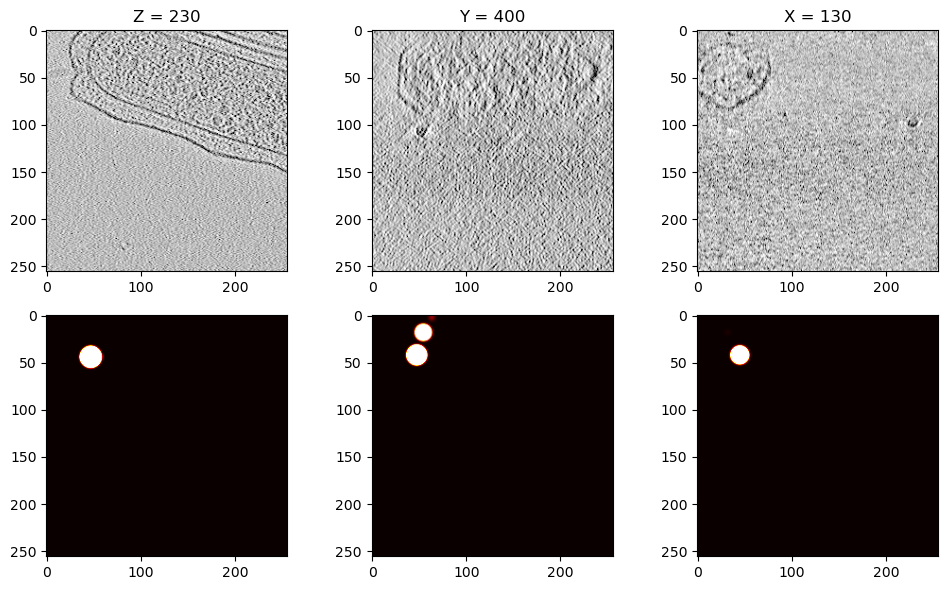

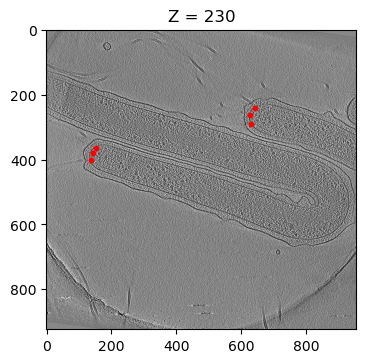

In [ ]:
import numpy as np
import torch
# cov = [[1e-4,0,0],[0,1e-4,0],[0,0,1e-4]]

tomo_id = 'tomo_00e463'
start_z = 190
start_y = 360
start_x = 90
label_tensor, voxel_tensor = process_train_slices(tomo_id=tomo_id, cov=cov, train_df=train_df, start_z=start_z, start_y=start_y, start_x=start_x)

def compare_slices(label_tensor:torch.Tensor):
    label_np = label_tensor.numpy()  # [Z, Y, X]
    mid_z, mid_y, mid_x = 40, 40, 40

    fig, axs = plt.subplots(2, 3, figsize=(10, 6))
    axs[0,0].set_title(f'Z = {start_z+mid_z}')
    axs[0,0].imshow(voxel_tensor[mid_z, :, :], cmap='gray')
    axs[1,0].imshow(label_np[mid_z, :, :], cmap='hot')
    axs[0,1].set_title(f'Y = {start_y+mid_y}')
    axs[0,1].imshow(voxel_tensor[:, mid_y, :], cmap='gray')
    axs[1,1].imshow(label_np[:, mid_y,:], cmap='hot')
    axs[0,2].set_title(f'X = {start_x+mid_x}')
    axs[0,2].imshow(voxel_tensor[:, :, mid_x], cmap='gray')
    axs[1,2].imshow(label_np[:, :, mid_x], cmap='hot')
    plt.tight_layout()
    plt.show()
    tomo_path = os.path.join(config.data_dir, 'train', tomo_id, f"slice_{start_z+mid_z:04d}.jpg")
    tomo = Image.open(tomo_path)
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    # 写真上にプロット
    ax.set_title(f'Z = {start_z+mid_z}')
    ax.imshow(tomo, cmap='gray')
    ax.scatter(motor_centers['Motor axis 2'], motor_centers['Motor axis 1'], c='red', s=10)
    plt.show()
# 実行
compare_slices(label_tensor)

Start position: 44, 200, 0


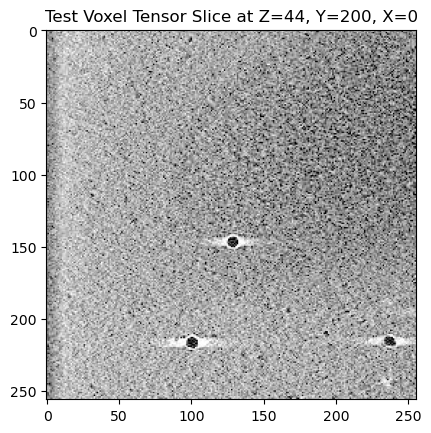

In [ ]:
tomo_id = 'tomo_00e047'
start_pos = (100, 200, 0)
img = Image.open(os.path.join(config.pred_dir, tomo_id, f"slice_0000.jpg"))
y_max, x_max = img.size
z_max = len(glob(os.path.join(config.pred_dir, tomo_id, '*.jpg')))
voxel_tensor, start_pos = process_test_slices(tomo_id=tomo_id, start_pos=start_pos, voxel_size=(z_max, y_max, x_max))
plt.imshow(voxel_tensor[0, :, :], cmap='gray')
plt.title(f"Test Voxel Tensor Slice at Z={start_pos[0]}, Y={start_pos[1]}, X={start_pos[2]}")
plt.show()

## Data augmentation